In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2

In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


In [4]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 30

DEVICE = 'cuda'

In [5]:
#Split del file csv da sottomettere alla rete neurale
df = pd.read_csv("spectrum_train_dataset.csv")
df.head()
#train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)
df_real = pd.read_csv("real_image_dataset.csv")
df_fake = pd.read_csv("fake_image_dataset.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])

train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)
#msk = np.random.rand(len(df)) <= 0.8
#train_df = df[msk]
#valid_df = df[~msk]
print(len(train_df))
print(len(valid_df))

96000
24000


In [6]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    
    #Permute because the third channel has to be in first channel in torch

    #A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    #P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    #N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0


    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img) / 255.0
    P_img = torch.from_numpy(P_img) / 255.0
    N_img = torch.from_numpy(N_img) / 255.0

    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train e il numero che compone l'insieme di dati di validation

In [8]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 96000
Size of validset: 24000


Carichiamo i dati di train e validation nella batch

In [9]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [10]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 3000
No. of batches in validloader : 750


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

In [11]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [12]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

model.to(DEVICE);

In [13]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    print(A_embs.shape)
      
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)

In [14]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [16]:
#Training
best_valid_loss = np.Inf
training_loss = []
validation_loss = []
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)
  training_loss.append(train_loss)
  validation_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'trained_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]

torch.Size([32, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [04:54<00:00,  2.55it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.00048072250684102374 valid_loss : 0.9999842095375061


  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]


torch.Size([32, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [02:46<00:00,  4.51it/s]

SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.00043268974622090656 valid_loss : 0.9999818476835887


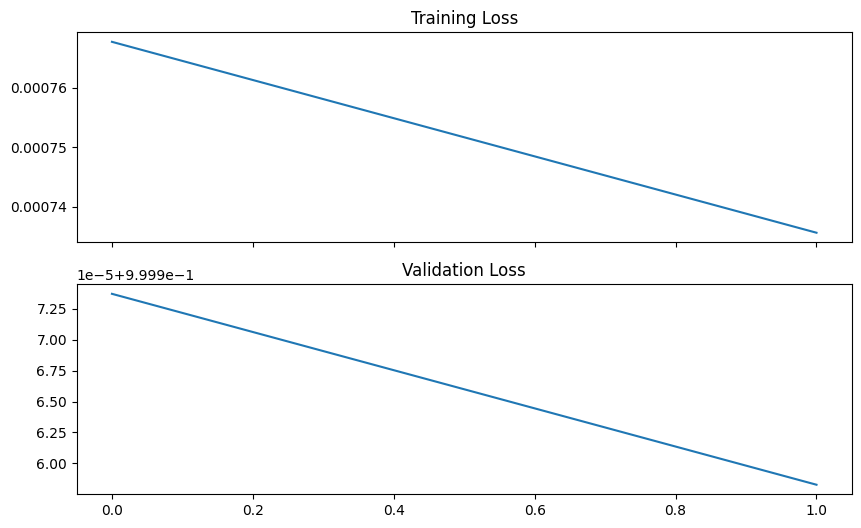

In [34]:
#Salvataggio plottato dei dati
fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
axes[0].plot(training_loss)
axes[0].set_title('Training Loss')
axes[1].plot(validation_loss)
axes[1].set_title('Validation Loss')
plt.savefig('training_data.png')
plt.show()

In [16]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      #A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [17]:
#QUI RICARICO IL MODELLO UNA VOLTA TRAINATO
model.load_state_dict(torch.load('trained_model.pt'))

#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:50<00:00, 86.75it/s]


In [18]:
#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
df_enc.to_csv('database.csv', index = False)

df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,dataset\coco\coco\coco2017\train_spectrum\img0...,0.133116,0.064841,0.174418,0.115637,0.121340,-0.035175,-0.022632,-0.025268,-0.066944,...,-0.217722,0.079276,0.014068,-0.039233,0.224695,-0.129345,0.254726,-0.093402,-0.262272,-0.213377
1,dataset\big_gan\big\biggan-spectrum\495\img004...,0.145088,0.082898,0.124771,0.002947,0.000588,-0.029483,0.159452,-0.029535,-0.073432,...,-0.484832,0.100996,0.124557,-0.121932,0.291947,-0.146839,0.201720,-0.027696,-0.259420,-0.108230
2,dataset\big_gan\big\biggan-spectrum\832\img008...,-0.017079,0.236167,0.263847,-0.052832,-0.091673,-0.040155,0.114168,0.014277,-0.147295,...,-0.183820,0.059114,0.052157,-0.273852,0.312125,-0.102795,0.166336,-0.031812,-0.242256,-0.270608
3,dataset\big_gan\big\biggan-spectrum\225\img001...,0.187560,0.172489,0.218494,0.036667,0.012987,0.028716,0.270279,0.037207,-0.191036,...,-0.567074,0.099479,0.144657,-0.124538,0.303917,-0.048026,0.221020,-0.061201,-0.177603,-0.158090
4,dataset\big_gan\big\biggan-spectrum\362\img002...,0.140636,0.132048,0.233123,-0.015523,-0.098646,-0.038024,0.325327,-0.017547,-0.229170,...,-0.461644,0.070251,0.094870,-0.217414,0.319907,-0.040396,0.095228,-0.050538,-0.355684,-0.161499


In [19]:
def euclidean_dist(img_enc, anc_enc_arr):
    #dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [20]:
df = pd.read_csv('testList.csv')
print(df['real'])
print(df.size)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'testList.csv'

In [3]:
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0);
    img = torch.from_numpy(img) / 255;
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE);
        img_enc = model(img.unsqueeze(0));
        img_enc = img_enc.detach().cpu().numpy();
        img_enc = np.array(img_enc);

    return img_enc;

In [4]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy();
    anc_img_names = database['Anchor'];

    distance = [];
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :]);
        distance = np.append(distance, dist);

    closest_idx = np.argsort(distance);

    return database['Anchor'][closest_idx[0]];

In [5]:
current_dir = os.getcwd()
DataTestReal = os.path.join(current_dir, "test")
y_true = []
y_pred = []
tempDf = df
tempDf.head()
tempDf.shape

NameError: name 'current_dir' is not defined

In [ ]:
#Testo i fake
currentTest = 'fake'
database = df_enc
# Prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows()):
    img_name = DataTestReal + row[currentTest];

    img = io.imread(img_name);

    img_enc = getImageEmbeddings(img, model);

    closestLabel = searchInDatabase(img_enc, database);

    if "real" in closestLabel:
        y_pred.append("real");
    else:
        y_pred.append("fake");

In [ ]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

In [ ]:
database = df_enc

In [ ]:
#Testo i real
currentTest = 'real'
## Prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows()):
    img_name = DataTestReal + row[currentTest]
    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    if "real" in closestLabel:
        y_pred.append("real")
    else:
        y_pred.append("fake")

In [ ]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

In [ ]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 1523)
print(y_true.shape)

temp = np.array(['real'] * 1523)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred, labels=["real", "fake"])

In [ ]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

In [ ]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})